In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as ep

ep.update_plot_defaults()

- Export the weights along the trajectory for both models
- combine
- PCA
- interpolate (+- 10%)
- create set of weights
- probe loss of both networks
    - convert BP net to ReLU before computing loss
- plot 2D loss landscape as 3D heatmap (including 2 actual trajectories, plot separately)

In [2]:
input_size = 21
dataset = torch.eye(input_size)
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), shuffle=True, generator=data_generator)

epochs=30
seed=42

### Gjorgjieva learning rule

In [3]:
network_config = ut.read_from_yaml('../optimize/data/20220902_EIANN_1_hidden_Gjorgieva_Hebb_config_A.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

gj_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

100%|██████████| 30/30 [00:01<00:00, 15.40it/s]


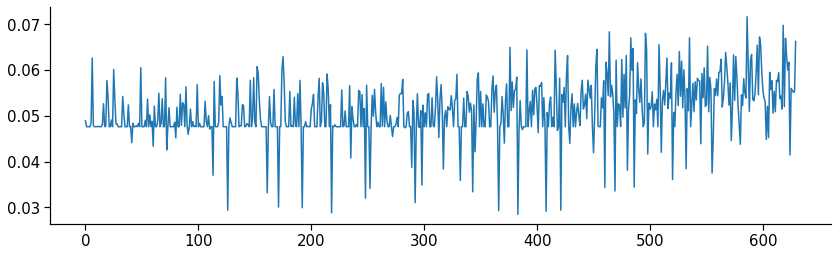

In [4]:
data_generator.manual_seed(data_seed)
gj_network.train(dataloader, epochs, store_history=True, status_bar=True)

plt.plot(gj_network.loss_history)
plt.show()

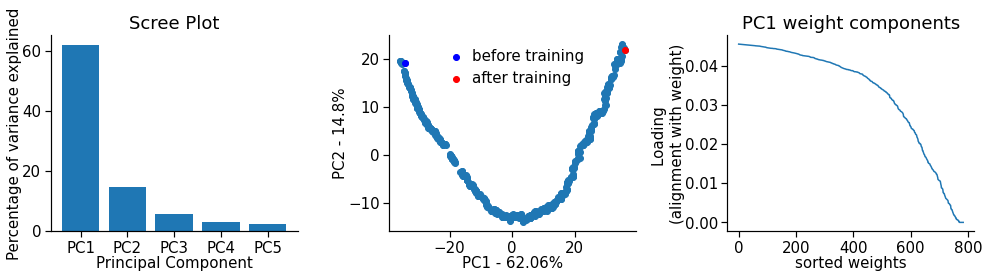

In [5]:
ep.plot_weight_history_PCs(gj_network)

  0%|          | 0/400 [00:00<?, ?it/s]/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 21])) that is different to the input size (torch.Size([21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [00:14<00:00, 26.83it/s]


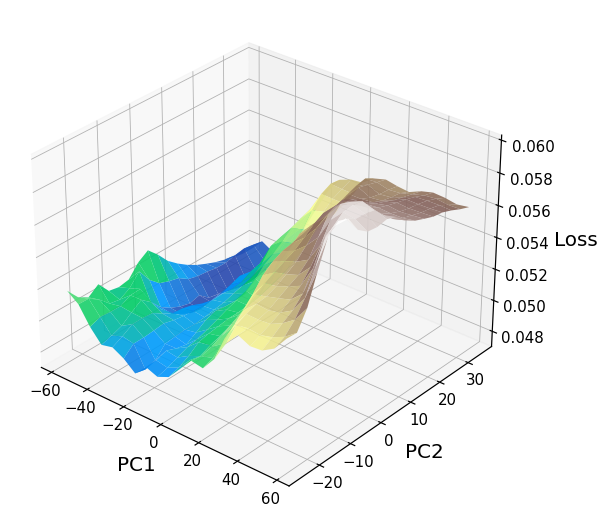

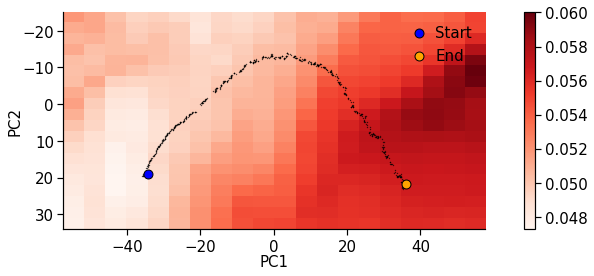

In [6]:
ds = [x for x in zip(dataset,target)]
test_dataloader = DataLoader(ds, batch_size=1)
ep.plot_loss_landscape(gj_network, test_dataloader, num_points=20)

### Backprop (softplus; SGD)

In [7]:
network_config = ut.read_from_yaml('../config/EIANN_1_hidden_backprop_softplus_SGD_matched_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

In [8]:
# # Initialize backprop net with same weights as Gjorg. init
# for i,gj_projection in enumerate(gj_network.module_list):
#     bp_network.module_list[i].weight.data = gj_projection.weight_history[0].clone()

# for gj_layer,bp_layer in zip(gj_network,bp_network):
#     for gj_pop,bp_pop in zip(gj_layer,bp_layer):
#         for gj_proj,bp_proj in zip(gj_pop,bp_pop):
#             bp_proj.weight.data = gj_proj.weight_history[0].clone()

100%|██████████| 30/30 [00:01<00:00, 17.69it/s]


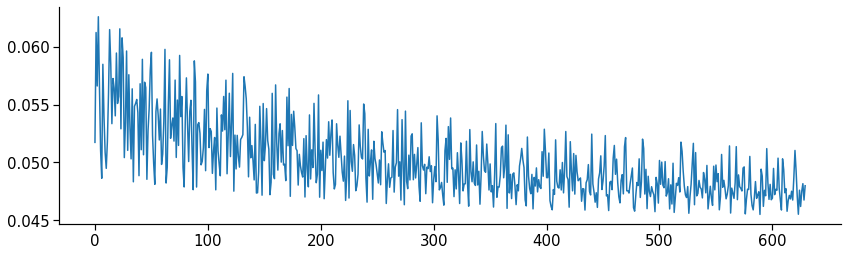

In [9]:
data_generator.manual_seed(data_seed)
bp_network.train(dataloader, epochs, store_history=True, status_bar=True)

plt.plot(bp_network.loss_history)
plt.show()

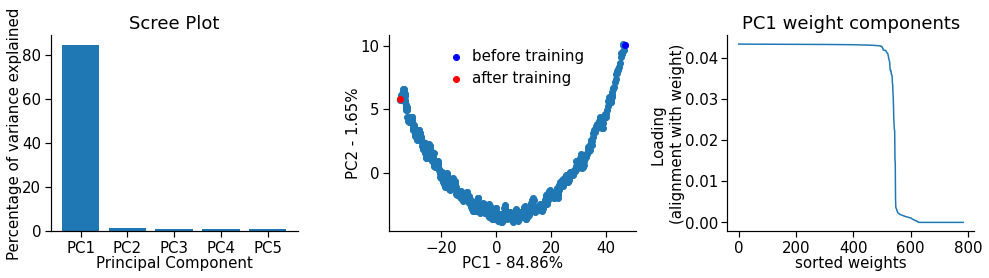

In [10]:
ep.plot_weight_history_PCs(bp_network)

  0%|          | 0/400 [00:00<?, ?it/s]/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 21])) that is different to the input size (torch.Size([21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [00:14<00:00, 27.87it/s]


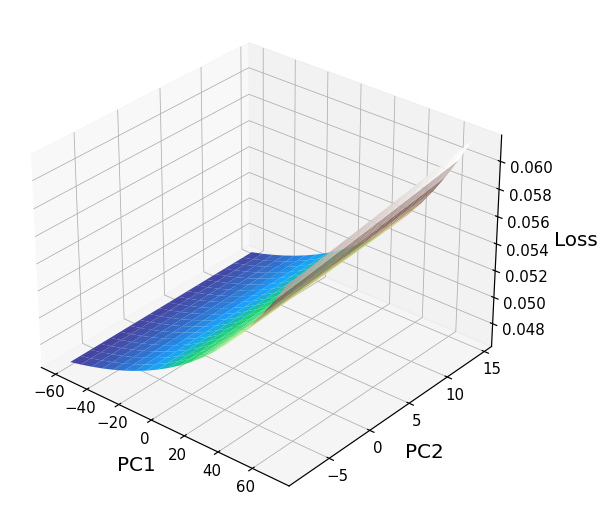

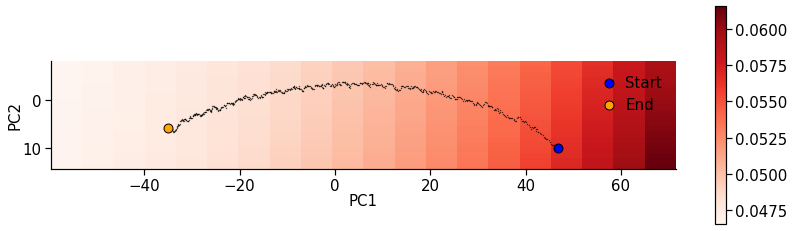

In [11]:
ep.plot_loss_landscape(bp_network, test_dataloader, num_points=20)

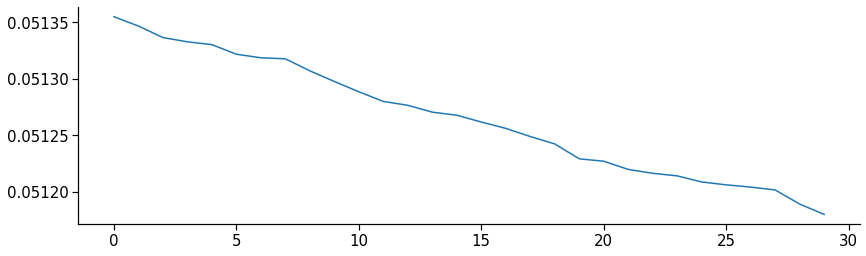

In [12]:
h = torch.mean(bp_network.module_list[0].weight_history,dim=(1,2))
plt.plot(h[0:30])

## Combined loss landscape

  0%|          | 0/400 [00:00<?, ?it/s]/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 21])) that is different to the input size (torch.Size([21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [00:12<00:00, 31.32it/s]


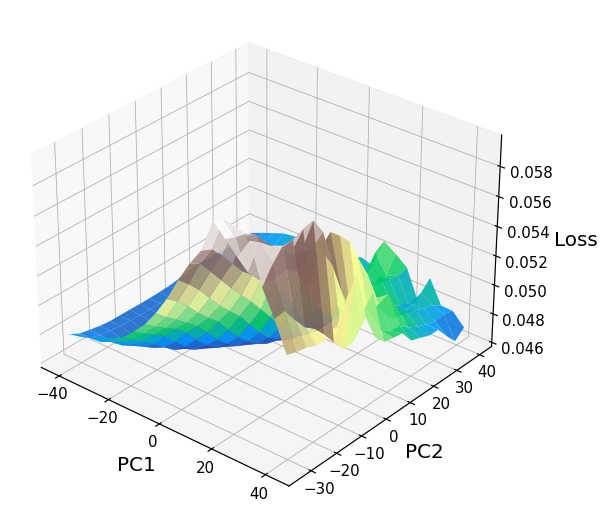

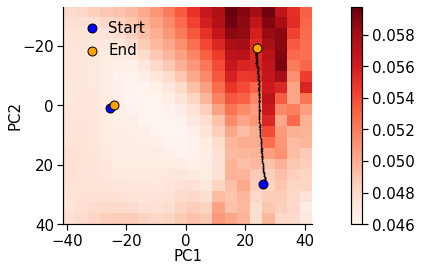

In [13]:
ep.plot_combined_loss_landscape(gj_network, bp_network, test_dataloader, num_points=20)